In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from datetime import datetime
from scipy import stats

In [ ]:
kickstarter = pd.read_csv('ks-projects-201801.csv', parse_dates = True)

In [7]:
kickstarter.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


I want to get rid of any rows with NA values in any of their columns. Then, I only want to focus on the most common main categories. To do so, I'll create a list of the most common and use that list to filter the dataset.

In [8]:
kickstarter.isna().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

In [9]:
kickstarter = kickstarter.dropna(subset = ['name'])
kickstarter = kickstarter.dropna(subset = ['usd pledged'])

In [10]:
kickstarter['deadline_year'] = kickstarter['deadline'].apply(lambda a: a[:4])

In [42]:
count = kickstarter['main_category'].value_counts()
# get nine categories with highest value counts
common = list(count[:9].keys())
# filter so that you only have the rows that are in those nine categories
most_common_cat = kickstarter[kickstarter['main_category'].isin(common)]

Let's visualize these categories

[Text(0, 0, 'Film & Video'),
 Text(0, 0, 'Music'),
 Text(0, 0, 'Publishing'),
 Text(0, 0, 'Games'),
 Text(0, 0, 'Technology'),
 Text(0, 0, 'Design'),
 Text(0, 0, 'Art'),
 Text(0, 0, 'Food'),
 Text(0, 0, 'Fashion')]

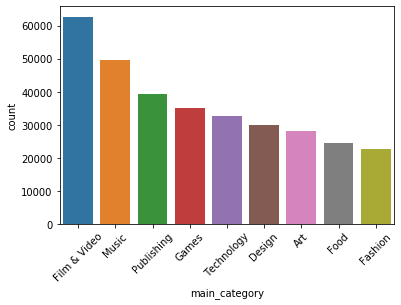

In [14]:
categoryCount = sns.countplot(x = 'main_category', data = most_common_cat, order = most_common_cat['main_category'].value_counts().index)
categoryCount.set_xticklabels(categoryCount.get_xticklabels(), rotation = 45)

In [24]:
#plot the main categories on the rows and the state in the columns, size() counts instances of each category for each state and reset_index()
# means index is removed
state_count = most_common_cat.groupby(['state', 'main_category']).size().reset_index().pivot(columns='state', index='main_category', values=0)
# create new column which is sum of three columns
state_count['total'] = state_count['canceled'] + state_count['failed'] + state_count['successful']
#sort table by total
state_count = state_count.sort_values(by = 'total', ascending = False)
state_count.head()

state,canceled,failed,live,successful,suspended,total
main_category,,,,,,
Film & Video,5744,32891,332,23612,117,62247
Music,3300,21696,281,24105,148,49101
Publishing,3601,23113,299,12300,66,39014
Games,6199,16002,287,12518,219,34719
Technology,4715,20613,377,6433,424,31761


In [25]:
#filter so that only states are 'canceled', 'failed', 'successful' and 'total'
state_count = state_count[['canceled', 'failed', 'successful', 'total']]
# sort by total
state_count = state_count.sort_values(by = 'total', ascending  = False)
state_count

state,canceled,failed,successful,total
main_category,,,,
Film & Video,5744,32891,23612,62247
Music,3300,21696,24105,49101
Publishing,3601,23113,12300,39014
Games,6199,16002,12518,34719
Technology,4715,20613,6433,31761
Design,4152,14814,10549,29515
Art,2222,14130,11510,27862
Food,2209,15969,6085,24263
Fashion,2650,14181,5593,22424


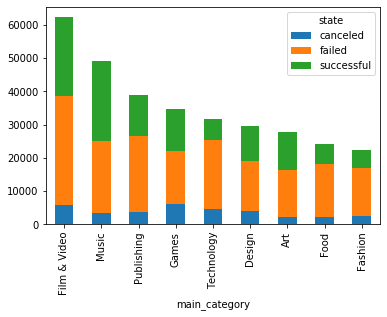

In [26]:
state_count.iloc[:, :3].plot(kind='bar', stacked=True)

In [27]:
state_count['success_rate'] = state_count['successful']/ state_count['total']

In [29]:
state_count.sort_values(by = "success_rate", ascending = False)

state,canceled,failed,successful,total,success_rate
main_category,,,,,
Music,3300,21696,24105,49101,0.490927
Art,2222,14130,11510,27862,0.413107
Film & Video,5744,32891,23612,62247,0.379328
Games,6199,16002,12518,34719,0.360552
Design,4152,14814,10549,29515,0.357411
Publishing,3601,23113,12300,39014,0.315271
Food,2209,15969,6085,24263,0.250793
Fashion,2650,14181,5593,22424,0.249420
Technology,4715,20613,6433,31761,0.202544


Next I'll graph the success rate and total number of projects using a dual axis.

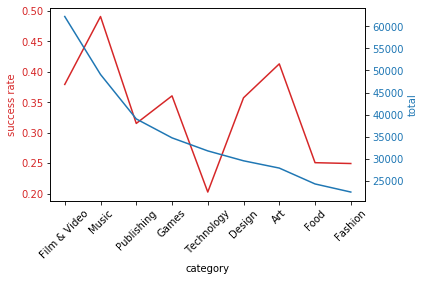

In [30]:
state_count = state_count.reset_index()
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('category')

ax1.set_ylabel('success rate', color = color)
ln1 = ax1.plot(state_count['main_category'], state_count['success_rate'], color = color)
ax1.tick_params(axis = 'y', labelcolor = color)
ax1.tick_params(axis = 'x', labelrotation = 45)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('total', color=color)
ln2 = ax2.plot(state_count['main_category'], state_count['total'], color=color)
ax2.tick_params(axis = 'y', labelcolor = color)

lns = ln1+ln2
labels = [l.get_label() for l in lns]

fig.tight_layout()
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
plt.show()

From the above chart, there seems to be some negative correlation with Art and Design not following this trend. There are some with high total and high success (film & video, music), low total and low success (food, fashion) and those with high total and low success (design and art). 

Next I would like to see how the number of projects changed throughout time. I will graph the monthly count against time. To do so, I will create two new columns: deadline month and deadline year by subscripting.

In [43]:
most_common_cat['deadline_month'] = most_common_cat['deadline'].apply(lambda a: a[0:7])
most_common_cat['deadline_year'] = most_common_cat['deadline'].apply(lambda a: a[0:4])

<ipython-input-43-796607592f8d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_common_cat['deadline_month'] = most_common_cat['deadline'].apply(lambda a: a[0:7])
<ipython-input-43-796607592f8d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_common_cat['deadline_year'] = most_common_cat['deadline'].apply(lambda a: a[0:4])


In [51]:
most_common_cat.deadline_month.isna().sum()
most_common_cat.deadline_year.isna().sum()

0

Then I will group the dataset by the main category and deadline month, while counting the number of projects in each 
grouped cell.

In [54]:
month_count = most_common_cat.groupby(['main_category', 'deadline_month']).size()
month_count = month_count.to_frame()
month_count['monthly count'] = month_count.iloc[:, 0]
month_count = month_count.reset_index()
month_count['deadline_month'] = pd.to_datetime(month_count['deadline_month'])
month_count = month_count.drop([0], axis =1)

In [55]:
month_count.head()

,main_category,deadline_month,monthly count
0,Art,2009-05-01,3
1,Art,2009-06-01,4
2,Art,2009-07-01,9
3,Art,2009-08-01,6
4,Art,2009-09-01,9


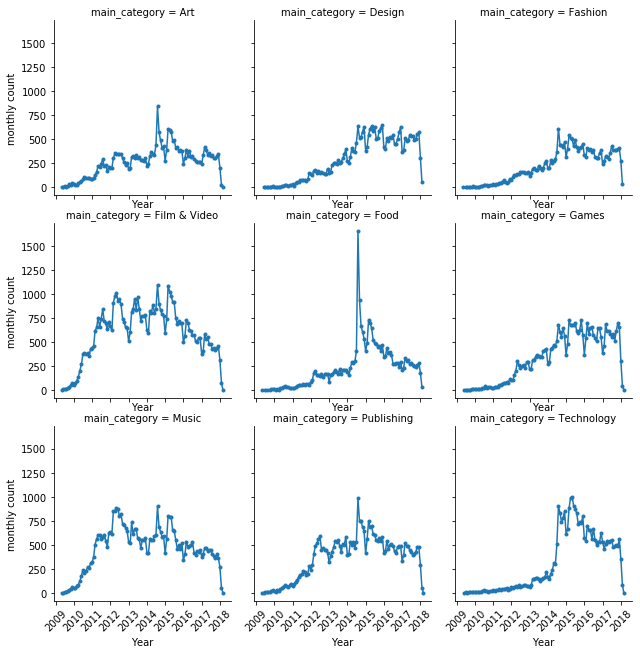

In [56]:
g = sns.FacetGrid(month_count, col = "main_category", col_wrap = 3)
g.map(plt.plot, "deadline_month", "monthly count", marker = ".")
for ax in g.axes.ravel():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_xlabel('Year')

The graphs above indicate that all categories roughly follow a similar path, whereby there is an incremental increase until around 2014. At around 2014, some categories see a steep increase. After 2015, there is either neglible change or a steady decline.

Next, I will graph the success rate of all categories aggregated

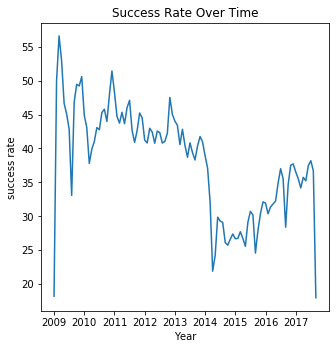

In [65]:
df_plot_month = most_common_cat.groupby(['state', 'deadline_month']).size().reset_index().pivot(columns='state', index='deadline_month', values = 0)
df_plot_month = df_plot_month[['canceled', 'failed', 'successful']]

df_plot_month['total'] = df_plot_month['canceled'] + df_plot_month['failed'] + df_plot_month['successful']
df_plot_month['success_rate'] = df_plot_month['successful']/df_plot_month['total']*100
df_plot_month = df_plot_month.reset_index()
df_plot_month['deadline_year'] = df_plot_month['deadline_month'].apply(lambda a: a[0:4])

labels = np.arange(2009, 2018, 1)
ticks = 2**labels
fig = plt.figure(1, figsize = (5,5))
ax = fig.add_axes([.1, .1, .8, .8])
ax.plot(df_plot_month['deadline_month'], df_plot_month['success_rate'])
ax.set_xticks([0, 12, 24, 36, 48, 60, 72, 84, 96])
ax.set_xticklabels(labels)
ax.set_xlabel("Year")
ax.set_ylabel("success rate")
ax.set_title('Success Rate Over Time')
plt.show()

There is a large jump in 2009. This is due to the small number of projects. Afterwards, the success rate largely stabilizes until 2014 where there is a sharp decline. This is likely connected to the large jump in number of projects seen by each category. Afterwards, there is an incremental increase in success rate, which mirrors many categories in the graphs seen before.

In [ ]:
Next I want to ascertain the correlation between success and number of projects. There was a graph above (In 30) that seemed
to indicate that certain categories had high number of projects and a high success rate. This is not the same as a positive
correlation. 

In [67]:
df_cat_month = most_common_cat.pivot_table(values = "usd_pledged_real", index = ['main_category', 'deadline_month'], columns = 'state', aggfunc = 'count')
df_cat_month = df_cat_month[['canceled', 'failed', 'successful']]
df_cat_month['total'] = df_cat_month['canceled'] + df_cat_month['failed'] + df_cat_month['successful']
df_cat_month['success_rate'] = df_cat_month['successful'] / df_cat_month['total']
df_cat_month.dropna(inplace = True)
df_resetIndex= df_cat_month.reset_index()
corr_df = pd.DataFrame(columns = ["Category", "Correlation"])
corr_df2 = pd.DataFrame({"Category": ["Art"], "Correlation": [.25]})
corr_df.append(corr_df2)
cat_num = 0
df_resetIndex['main_category'].unique()
for cat in df_resetIndex['main_category'].unique():
    cat_df = df_resetIndex[df_resetIndex['main_category'] == cat]
    corr = np.corrcoef(cat_df['total'], cat_df['success_rate'])[0, 1]
    #print(corr)
    corr_df2 = pd.DataFrame({"Category": [cat], "Correlation": [corr]})
    corr_df = corr_df.append(corr_df2)

In [68]:
corr_df.sort_values(by = "Correlation")

,Category,Correlation
0,Technology,-0.673995
0,Food,-0.642954
0,Art,-0.394340
0,Fashion,-0.344734
0,Publishing,-0.320587
0,Music,-0.117553
0,Film & Video,-0.061892
0,Design,0.007034
0,Games,0.155999


There are two relevant effects here. The low number of projects and the degree to which an additional project affects success rate. For instance, a category could be very affected by an increase in number of projects, but still have a high success rate due to the limited number of projects. This would be reflected in the first graph as high success and low total and the correlation would be at least moderately negative. I would hazard a guess that categories that had high success and low total, would have that success due to the low total, if they also had a substantial negative correlation. This is the case with the category Art. However, Design, the other category that had low total and high success, had virtually zero correlation. 

There were some categories with low success and low total. These were technology, food and fashion. In the case of technology, it could be that the high median goal meant that there would be low success, however the substantial negative correlation indicates that perhaps technology was heavily affected by increases in number of projects. Indeed, the graph at in[56] indicates a substantial increase in number of projects. It would be helpful to see if there is a likewise decrease in success rate at this time. Food and fashion also have some of the most negative correlations. 

The two categories with high success rates and high number of projects are film & video and music. As well, they have only a little bit of a negative correlation between success and number of projects. 

I want to use regression to test how each category's success rate responds to change in number of backers, average donation and 
goal in dollars. To do so, I first have to create a new column in most_common_cat that contains the average donation for each project. Next, I create a pivot table for goal, backers and average donation whereby the value will be the median values for each. 

In [69]:
most_common_cat = most_common_cat[most_common_cat['backers'] > 0]
most_common_cat['average_donation'] = most_common_cat['usd_pledged_real'] / most_common_cat['backers']

In [86]:
df_avg_donation = most_common_cat.pivot_table(values = "average_donation", index = ['main_category', 'deadline_month'], columns = 'state', aggfunc = np.median, margins = True)
df_goal = most_common_cat.pivot_table(values = "goal", index = ['main_category', 'deadline_month'], columns = 'state', aggfunc = np.median, margins = True)
df_backers = most_common_cat.pivot_table(values = "backers", index = ['main_category', 'deadline_month'], columns = 'state', aggfunc = np.median, margins = True)

In [73]:
df_avg_donation.head()

state                         canceled      failed  live  successful  \
main_category deadline_month                                           
Art           2009-05              NaN   25.000000   NaN   11.666667   
              2009-06              NaN   31.944444   NaN  114.659091   
              2009-07              NaN   18.870370   NaN   19.545455   
              2009-08              NaN   16.250000   NaN   33.394737   
              2009-09              NaN  112.500000   NaN   31.997283   

state                         suspended        All  
main_category deadline_month                        
Art           2009-05               NaN  18.333333  
              2009-06               NaN  39.097222  
              2009-07               NaN  19.545455  
              2009-08               NaN  26.000000  
              2009-09               NaN  35.625000

By setting margins = True in pivot_table() there will be one row at the bottom that I don't need, so I delete this row.

In [87]:
df_avg_donation = df_avg_donation.iloc[:-1]
df_goal = df_goal.iloc[:-1]
df_backers = df_backers.iloc[:-1]

Next, I want the success rate for each month to be a column in each pivot table. One way to do this (incorrectly) is to add a column df_aveage_donation['success_rate'] = df_cat_month['success_rate']. Remember that df_cat_month is the pivot table that calculates the total number of projects for each state and has a column for success rate for each month. The problem with this apporach is that the two dataframes will have a different number of rows. Thus, I will need to merge the two dataframes. I don't need most of the columns in df_cat_month, so I create a new dataframe that filters out most columns.

In [88]:
df_cat_month = df_cat_month.reset_index()
deadline_success = df_cat_month[['deadline_month', 'main_category', 'success_rate']]

In [79]:
deadline_success.head()

state,deadline_month,main_category,success_rate
0,2009-10,Art,0.343750
1,2009-11,Art,0.450000
2,2009-12,Art,0.431818
3,2010-01,Art,0.481481
4,2010-02,Art,0.421053


Next, I merge the two dataframes with an inner merge on both deadline_month and main_category. Doing merge on just one of those columns would result in too many rows as each month and category has multiple rows associated with it in the other dataframe.

In [89]:
df_avg_donation = df_avg_donation[['canceled', 'failed', 'successful', 'All']]
df_avg_donation = pd.merge(df_avg_donation, deadline_success, how = 'inner', on = ['deadline_month', 'main_category'])
df_avg_donation.dropna(inplace = True)
df_avg_donation.reset_index(inplace = True)

In [90]:
df_goal = df_goal[['canceled', 'failed', 'successful', 'All']]
df_goal = pd.merge(df_goal, deadline_success, how = 'inner', on = ['deadline_month', 'main_category'])
df_goal.dropna(inplace = True)
df_goal.reset_index(inplace = True)

In [91]:
df_backers = df_backers[['canceled', 'failed', 'successful', 'All']]
df_backers = pd.merge(df_backers, deadline_success, how = 'inner', on = ['deadline_month', 'main_category'])
df_backers.dropna(inplace = True)
df_backers.reset_index(inplace = True)

In [92]:
df_backers.head()

state,index,deadline_month,main_category,canceled,failed,successful,All,success_rate
0,0,2009-10,Art,5.5,11.0,29.0,12.0,0.343750
1,1,2009-11,Art,3.5,4.0,49.0,20.0,0.450000
2,2,2009-12,Art,11.0,5.5,33.0,13.0,0.431818
3,3,2010-01,Art,13.5,5.5,34.0,18.0,0.481481
4,4,2010-02,Art,33.0,6.0,41.0,17.0,0.421053


In [85]:
df_goal.head()

state,index,deadline_month,main_category,canceled,failed,successful,All,success_rate
0,0,2009-10,Art,2740.0,3000.0,2000.00,2611.0,0.343750
1,1,2009-11,Art,6121.5,2000.0,2000.00,2250.0,0.450000
2,2,2009-12,Art,7000.0,5425.0,1824.79,2500.0,0.431818
3,3,2010-01,Art,6250.0,5500.0,1200.00,2260.0,0.481481
4,4,2010-02,Art,8000.0,3500.0,1450.00,3000.0,0.421053


Concatenate the relevant columns in each dataframe, then change the name of columns that have the same name. Dummify the categorical colummn and drop the first category so that there is no multicollinearity. This category is Art and thus the coefficient for the other categories can be treated as a comparison between the success rate of Art and success rate of that category. Assign independent variables and dependent variable to X and y, respectively.  

I want to check if the independent variables are normally distributed. In the case of number of backers this does not seem to be the case, as there is noticeable skewness.

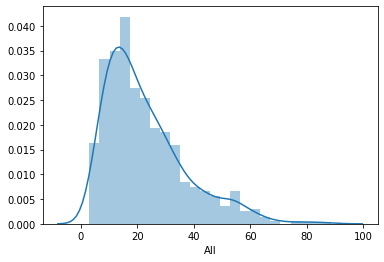

In [98]:
sns.distplot(df_backers['All'])

If I log this column then the skewness goes away.

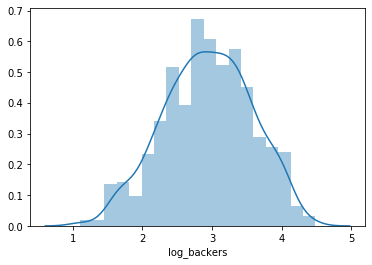

In [101]:
df_backers['log_backers'] = np.log(df_backers['All'])
sns.distplot(df_backers['log_backers'])

In [104]:
concat_tables = pd.concat([df_goal['main_category'], df_avg_donation['All'], df_goal['All'], df_backers['log_backers'], df_backers['success_rate']], axis = 1)
concat_tables.columns = ['main_category', 'average pledge', 'goal', 'log backers', 'success rate']
categories = pd.get_dummies(concat_tables['main_category'], drop_first = True)
X = concat_tables[['average pledge', 'goal', 'log backers']]
X = pd.concat([categories, X], axis = 1)
y = concat_tables[['success rate']]

In [105]:
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           success rate   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     371.2
Date:                Wed, 06 May 2020   Prob (F-statistic):          6.00e-315
Time:                        09:14:58   Log-Likelihood:                 1453.9
No. Observations:                 859   AIC:                            -2884.
Df Residuals:                     847   BIC:                            -2827.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0799      0.011      7.442      0.000       0.059       0.101
Design            -0.1174      0.008    -14.216      0.000      -0.134      -0.101
Fashion           -0.1099      0.007    -15.734      0.000      -0.124      -0.096
Film & Video      -0.0577      0.007     -7.801      0.000      -0.072      -0.043
Food              -0.0679      0.008     -8.837      0.000      -0.083      -0.053
Games             -0.1114      0.008    -13.236      0.000      -0.128      -0.095
Music              0.0057      0.007      0.865      0.387      -0.007       0.019
Publishing        -0.0732      0.007    -11.161      0.000      -0.086      -0.060
Technology        -0.0815      0.010     -7.868      0.000      -0.102      -0.061
average pledge     0.0012      0.000      4.863      0.000       0.001       0.002
goal           -7.494e-06   5.75e-07    -13.032      0.000   -8.62e-06   -6.37e-06
log backers        0.1160      0.004     33.022      0.000       0.109       0.123
==============================================================================
Omnibus:                      100.717   Durbin-Watson:                   1.594
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              802.129
Skew:                          -0.147   Prob(JB):                    6.61e-175
Kurtosis:                       7.725   Cond. No.                     1.02e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.02e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""